In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from scipy.stats import lognorm as lnorm
from primitives import Parameters
p = Parameters()
import opt_einsum as oe
from primitives import Preferences
from probabilities import createPoissonTransitionMatrix,createBlockPoissonTransitionMatrix
from search import JobSearchArray
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
def impose_decreasing(M):
    nv = M.shape[1]
    for v in reversed(range(nv-1)):
        M[:,v,:] = np.maximum(M[:,v,:],M[:,v+1,:])
    return M
def impose_increasing(A0):
    A = np.copy(A0)
    nv = len(A)
    for v in range(1,nv):
        A[v] = np.maximum(A[v],A[v-1])
    return A
ax = np.newaxis
class StateBoundsProcessor:
    def __init__(self, lower_bounds, upper_bounds):
        """
        Initialize with lower and upper bounds for each state dimension
        
        Args:
            lower_bounds: List or tensor of lower bounds [x_1, x_2, ..., x_20]
            upper_bounds: List or tensor of upper bounds [y_1, y_2, ..., y_20]
        """
        self.lower_bounds = torch.tensor(lower_bounds, dtype=torch.float32)
        self.upper_bounds = torch.tensor(upper_bounds, dtype=torch.float32)
        self.range = self.upper_bounds - self.lower_bounds
        
    def normalize(self, states):
        """Scale states from [lower_bound, upper_bound] to [-1, 1]"""
        return 2 * (states - self.lower_bounds) / self.range - 1
        #Example: lower-upper is [0,1]. So normalize(0.5) = 2 * (0.5 - 0) /1 -1 = 0. Ok correct
        #Another example. lower-upper is [0,30]. Sn normalize 15= 2 * 15 / 30 -1 = 0 Ok good.
        # And normalize (20) = 40/30 - 1 = 1/3 yup
        # Now denormalize(1/3) = 0.5 ( 1/3 +1 ) * 30 + 0 = 2/3*30 = 20
        
    def denormalize(self, normalized_states):
        """Convert normalized states back to original range"""
        return 0.5 * (normalized_states + 1) * self.range + self.lower_bounds
class ValueFunctionNN(nn.Module):
    """Neural network to approximate the value function"""
    def __init__(self, state_dim, hidden_dims=[40, 30, 20, 10]):
        super(ValueFunctionNN, self).__init__()
        
        # Build layers
        layers = []
        input_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.Softplus())  # SiLU activation function
            # Consider adding layer normalization for stability
            #layers.append(nn.LayerNorm(hidden_dim))
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, 1)) #was input_dim instead of 16
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [28]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)  
cc.w_grid[0]

0.05

In [24]:
range(0)

range(0, 0)

In [2]:
class FOCOptimizer:
    """
    Class to solve first-order conditions given a state and value function
    This is a placeholder - you'll need to implement actual FOC logic
    """
    def __init__(self, state_dim, action_dim, value_function_model, bounds_processor, parameters=None, js=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.bounds_processor = bounds_processor  # Store bounds_processor

        self.p = parameters
        self.deriv_eps = 1e-4 # step size for derivative
        # Model preferences initialized by the same parameter object.
        self.pref = Preferences(input_param=self.p)

        # Worker and Match Productivity Heterogeneity in the Model
        self.Z_grid = self.construct_z_grid()   # Create match productivity grid

        # Production Function in the Model
        self.fun_prod = self.p.prod_a * np.power(self.Z_grid, self.p.prod_rho)
        # Unemployment Benefits across Worker Productivities
        self.unemp_bf = self.p.u_bf_m

        # Transition matrices
        self.Z_trans_mat = createPoissonTransitionMatrix(self.p.num_z, self.p.z_corr)

        # Value Function Setup
        self.J_grid   = -10 * np.ones((self.p.num_v)) #grid of job values, first productivity, then starting value, then tenure level
        self.w_grid = np.linspace(self.unemp_bf, self.fun_prod.max(), self.p.num_v )
        self.rho_grid=1/self.pref.utility_1d(self.w_grid)
        # Normalize rho_grid to tensor for model input
        self.rho_normalized = self.bounds_processor.normalize(torch.tensor(self.rho_grid, dtype=torch.float32)).unsqueeze(1)

        
        #Gotta fix the tightness+re functions somehow. Ultra simple J maybe?
        self.v_grid=np.linspace(np.divide(self.pref.utility(self.unemp_bf),1-self.p.beta), np.divide(self.pref.utility(self.fun_prod.max()),1-self.p.beta), self.p.num_v ) #grid of submarkets the worker could theoretically search in. only used here for simplicity!!!
        self.simple_J=np.divide(self.fun_prod[self.p.z_0-1,ax] -self.pref.inv_utility(self.v_grid[:]*(1-self.p.beta)),1-self.p.beta)
        self.simple_Rho = self.simple_J + self.rho_grid * self.v_grid #We do indeed need to work with Rho here since we're taking W via its derivatives
        #Apply the matching function: take the simple function and consider its different values across v.
        self.prob_find_vx = self.p.alpha * np.power(1 - np.power(
            np.divide(self.p.kappa, np.maximum(self.simple_J[ :], 1.0)), self.p.sigma), 1/self.p.sigma)
        #Now get workers' probability to find a job while at some current value, as well as their return probabilities.
        if js is None:
            self.js = JobSearchArray() #Andrei: note that for us this array will have only one element
            self.js.update(self.v_grid[:], self.prob_find_vx) #Andrei: two inputs: worker's value at the match quality of entrance (z_0-1), and the job-finding probability for the whole market
        else:
            self.js = js
        #Note: I think??? js takes the values over the uniform grid only. so if I use NNs, gotta adapt it. But for now forget about updating it, keep it as is

    def getWorkerDecisions(self, EW1, employed=True): #Andrei: Solves for the entire matrices of EW1 and EU
        """
        :param EW1: Expected value of employment
        :param EU:  Expected value of unemployment
        :param employed: whether the worker is employed (in which case we multiply by efficiency)
        :return: pe,re,qi search decision and associated return, as well as quit decision.
        """
        pe, re = self.js.solve_search_choice(EW1) #Uses the job search array to solve for the search choice
        assert (~np.isnan(pe)).all(), "pe is not NaN"
        assert (pe <= 1).all(), "pe is not less than 1"
        assert (pe >= -1e-10).all(), "pe is not larger than 0"
        ve = self.js.ve(EW1)
        if employed:
            pe = pe * self.p.s_job
            re = re * self.p.s_job
        #print("Shape of pe:", pe.shape)
        # construct the continuation probability. #Andrei: probability the worker doesn't get fired and also doesn't leave
        pc = (1 - pe)

        return ve, re, pc #ve is vhat, the value the worker gets upon finding a job
    def matching_function(self,J1): #Andrei: the formula of their matching function, applied to each particula job value J1
        return self.p.alpha * np.power(1 - np.power(
            np.divide(self.p.kappa, np.maximum(J1, self.p.kappa)), self.p.sigma),
                                1 / self.p.sigma)
    def construct_z_grid(self):
        """
            Construct a grid for match productivity heterogeneity.
        """

        exp_z = np.tile(np.linspace(0, 1, self.p.num_z + 2)[1:-1][:],
                        (1))

        return lnorm.ppf(q=exp_z, s=self.p.prod_var_z)    
    def solve_foc(self, states, value_function_model):
        """
        Solves first-order conditions to find optimal action and next state
        
        Args:
            state: Current state tensor
            value_function_model: Neural network model for value function
        
        Returns:
            Dictionary with optimal action, next state, and immediate reward
        """
        # This is a placeholder - replace with your actual FOC solver
        # In a real implementation, you would:
        # 1. Set up an optimization problem to find action that maximizes reward + discounted future value
        # 2. Use value_function_model to evaluate future values
        # 3. Return optimal action and resulting next state
        # Compute gradient with gradients enabled
        EW=self.EW
        with torch.no_grad():
            self.vf_output = value_function_model(self.rho_normalized).squeeze(1).numpy() #This EJpi from the CC FOC. I just precompute it for every point here
        # Placeholder implementation (just random actions and states)
        with torch.no_grad():
            states_denorm = self.bounds_processor.denormalize(states).numpy()
            # get worker decisions
            _, _, pc = self.getWorkerDecisions(EW) #This EW1i is computed by taking the derivative of Rho, which is our core value function, wrt rho, which is the value-related state-variable
            # get worker decisions at EW1i + epsilon
            _, _, pc_d = self.getWorkerDecisions(EW + self.deriv_eps)
            log_diff = np.zeros_like(self.rho_grid)
            log_diff[:] = np.nan
            log_diff[pc > 0] = np.log(pc_d[pc > 0]) - np.log(pc[pc > 0]) #This is log derivative of pc wrt the promised value
            foc = self.rho_grid[:] - self.vf_output * log_diff / self.deriv_eps #So the FOC wrt promised value is: pay shadow cost lambda today (rho_grid), but more likely that the worker stays tomorrow
            assert (np.isnan(foc) & (pc > 0)).sum() == 0, "foc has NaN values where p>0"

                    #Andrei: so we look for the shadow cost that will satisfy the foc? Yes, look for u'(w'), with u'(w) given, so that the foc is satisfied
                    # look for FOC below  rho_0

            rho_star = np.interp(states_denorm,
                                        impose_increasing(foc),
                                        self.rho_grid)
            rho_star_tensor = torch.tensor(rho_star, dtype=torch.float32)

            action = rho_star_tensor
            next_state = self.bounds_processor.normalize(rho_star_tensor)
            reward = self.fun_prod[p.z_0-1] - np.interp(rho_star,self.rho_grid,self.w_grid) + states_denorm * self.pref.utility(np.interp(rho_star,self.rho_grid,self.w_grid))  # The entire Rho here. Big note though: this should be today's W, not EW
            reward = torch.tensor(reward, dtype=torch.float32)



        return {
            "action": action,
            "next_state": next_state,
            "reward": reward
        }
    def get_batch_gradients(self,states, value_function_model):
        states = states.detach().clone().requires_grad_(True)
        values = value_function_model(states)
    
        # Sum values to get scalar for backward pass
        values.sum().backward(retain_graph=True)
    
        gradients = states.grad.clone()
        # Clear gradients for next computation
        states.grad.zero_()
        gradients = gradients / (0.5 * self.bounds_processor.range) #Normalize the gradient back to the original (not [-1,1]) state space

        return gradients    
    def get_value_function_gradient(self,state, value_function_model):
        # Ensure state requires gradients
        #if not state.requires_grad:
        state = state.detach().clone().requires_grad_(True)
    
        # Forward pass
        value = value_function_model(state)
    
        # Compute gradient of value with respect to state
        #value.retain_grad()
        value.sum().backward(retain_graph=True)

        # Extract gradient
        gradient = state.grad.clone()
    
        # Clear gradients for next computation
        state.grad.zero_()
        gradient = gradient / (0.5 * self.bounds_processor.range) #Normalize the gradient back to the original (not [-1,1]) state space
        return gradient
    #This can definitely be vectorized. So far each trajectory is done completely separately, even though the operations at each step are the same, no?
    def simulate_trajectory(self,state, value_function_model, foc_optimizer, steps=5):
        """
        Simulate a trajectory starting from a state and using the current value function
    
        Args:
            state: Starting state tensor
            value_function_model: Current value function model
            foc_optimizer: Optimizer to solve FOCs
            steps: Number of steps to simulate
        
        Returns:
            Total discounted reward and final state value
        """
        total_reward = 0
        discount = 1.0
    
        current_state = state.clone()
        with torch.enable_grad():
            EW_tensor = self.get_batch_gradients(self.rho_normalized, value_function_model)[:,0] #This isn't even correct! I should be taking this at all the rho's!
        self.EW = EW_tensor.detach().numpy()  # Convert to NumPy for further processing
        for _ in range(steps):
            
            # Solve FOC to get optimal action and next state
            result = foc_optimizer.solve_foc(current_state, value_function_model)
            #Probability that the worker stays
            EW_star = self.get_batch_gradients(result["next_state"].unsqueeze(1).requires_grad_(True), value_function_model)[:,0]
            ve_star, __, pc_star = self.getWorkerDecisions(EW_star.numpy())
            ve_star = torch.from_numpy(ve_star)
            pc_star = torch.from_numpy(pc_star)            
            # Accumulate discounted reward
            if _<range(steps)[-1]:
                total_reward += discount * result["reward"] + self.p.beta * self.bounds_processor.denormalize(current_state) * ( 1 - pc_star) * ve_star  #This should be: reward + rho*beta*ve_star*pe_star (so the value worker gets from leaving) + discount*next_reward
            else:
                total_reward += discount * result["reward"] #for the last period we don't enymore do ve_star as that's included... right? confirm later
            # Update state and discount factor
            current_state = result["next_state"]
            discount *= self.p.beta * pc_star
    
        # Add final state value
        with torch.no_grad():
            final_value = value_function_model(current_state.unsqueeze(1).requires_grad_(True))
    
        total_value = total_reward + discount * final_value
    
        return total_value, current_state

In [3]:
def train_value_function(
    state_dim,
    lower_bounds,
    upper_bounds,
    action_dim=5,
    hidden_dims=[40, 30, 20, 10],
    num_iterations=20, 
    starting_points_per_iter=100,
    simulation_steps=5,
    learning_rate=0.001,
    parameters=None
):
    """
    Main training loop for value function approximation
    
    Args:
        state_dim: Dimension of state space
        action_dim: Dimension of action space
        hidden_dims: List of hidden layer dimensions
        num_iterations: Number of training iterations
        starting_points_per_iter: Number of starting points per iteration
        simulation_steps: Steps to simulate for each starting point
        learning_rate: Learning rate for neural network optimizer
        discount_factor: Discount factor for future rewards
    
    Returns:
        Trained value function model
    """
    bounds_processor = StateBoundsProcessor(lower_bounds,upper_bounds)
    # Initialize value function neural network
    value_function_model = ValueFunctionNN(state_dim, hidden_dims)
    from ContinuousContract import ContinuousContract
    cc=ContinuousContract(p)
    # Initialize FOC optimizer
    foc_optimizer = FOCOptimizer(state_dim, action_dim, value_function_model, bounds_processor, parameters, cc.js)
    
    # Initialize neural network optimizer
    optimizer = optim.Adam(value_function_model.parameters(), lr=learning_rate)
    
    #Step 0: basic guess    
    cc_J,cc_W,_,_ = cc.J()
    target_values = torch.tensor(cc_J[p.z_0-1,:] + cc.rho_grid * cc_W[p.z_0-1,:], dtype=torch.float32)
    states=bounds_processor.normalize(torch.tensor(foc_optimizer.rho_grid, dtype=torch.float32)).unsqueeze(1).requires_grad_(True) #This should be renormalized... right?
    #print(np.max(np.abs(cc.rho_grid-foc_optimizer.rho_grid)))
    #target_values=torch.tensor(foc_optimizer.simple_Rho, dtype=torch.float32)
    for _ in (range(50)):
        optimizer.zero_grad()
        predicted_values = value_function_model(states)[:,0]
        loss = nn.MSELoss()(predicted_values, target_values)
        loss.backward() #
        optimizer.step()

    # Training loop
    for iteration in tqdm(range(num_iterations)):
        # Generate uniform random starting states
        states_denormal = torch.rand(starting_points_per_iter, state_dim,dtype=torch.float32) * bounds_processor.range + torch.tensor(lower_bounds,dtype=torch.float32) #Turning lower_bounds into torch every time is wasteful
        states = bounds_processor.normalize(states_denormal).requires_grad_(True)
        #print("States shape", states.shape)
        # Calculate target values through simulation
        target_values = []

        # Simulate trajectory and get total discounted reward
        target_values, _ = foc_optimizer.simulate_trajectory(
            states[:,0], value_function_model, foc_optimizer, simulation_steps)
        #target_values.append(total_values)
        
        #target_values = torch.tensor(target_values, dtype=torch.float32)
        
        # Update neural network based on simulated values
        optimizer.zero_grad()
        predicted_values = value_function_model(states)
        loss = nn.MSELoss()(predicted_values, target_values)
        loss.backward() #
        optimizer.step()
        
        # Print progress
        if (iteration + 1) % 5 == 0 or iteration == 0:
            print(f"Iteration {iteration + 1}, Loss: {loss.item():.6f}")
    
    return value_function_model

In [4]:
def evaluate_value_function(model, p, lower_bounds,upper_bounds):
    """
    Evaluate the trained value function on test points
    
    Args:
        model: Trained value function model
        num_test_points: Number of test points
        state_dim: Dimension of state space
    """

    bounds_processor = StateBoundsProcessor(lower_bounds,upper_bounds)
    # Generate random test states
    #test_states = torch.randn(num_test_points, state_dim)
    from ContinuousContract import ContinuousContract
    cc=ContinuousContract(p)    
    cc_J,cc_W,_,_ = cc.J()
    cc_Rho = cc_J[p.z_0-1,:] + cc.rho_grid * cc_W[p.z_0-1,:]
    test_states = bounds_processor.normalize(torch.tensor(cc.rho_grid, dtype=torch.float32)).unsqueeze(1)
    # Evaluate model
    with torch.no_grad():
        values = model(test_states)
    
    # Print results
    #print("\nValue function evaluation on test states:")
    #for i in range(min(5, num_test_points)):
    #    print(f"State {i+1}: Value = {values[i].item():.4f}")
    #Plot results
    plt.plot(cc.rho_grid, cc_Rho, label = "VFI")
    plt.plot(cc.rho_grid, values, label = "NN")    
    plt.show()

Training value function...


  0%|          | 0/690 [00:00<?, ?it/s]c:\Programs\Python 3.11\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([200, 200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 11/690 [00:00<00:06, 107.79it/s]

Iteration 1, Loss: 76970.539062
Iteration 5, Loss: 72109.554688
Iteration 10, Loss: 67536.468750
Iteration 15, Loss: 64638.335938
Iteration 20, Loss: 61628.710938


  5%|▍         | 34/690 [00:00<00:06, 100.57it/s]

Iteration 25, Loss: 56396.363281
Iteration 30, Loss: 55585.351562
Iteration 35, Loss: 55838.453125
Iteration 40, Loss: 58460.312500


  8%|▊         | 56/690 [00:00<00:06, 96.84it/s] 

Iteration 45, Loss: 57278.343750
Iteration 50, Loss: 52494.667969
Iteration 55, Loss: 45388.777344
Iteration 60, Loss: 49214.507812
Iteration 65, Loss: 41844.488281


 13%|█▎        | 88/690 [00:00<00:06, 99.15it/s] 

Iteration 70, Loss: 45584.929688
Iteration 75, Loss: 41550.546875
Iteration 80, Loss: 36385.421875
Iteration 85, Loss: 35478.015625
Iteration 90, Loss: 34189.691406


 16%|█▌        | 108/690 [00:01<00:05, 98.48it/s]

Iteration 95, Loss: 28260.531250
Iteration 100, Loss: 31917.298828
Iteration 105, Loss: 24590.832031
Iteration 110, Loss: 25988.365234
Iteration 115, Loss: 27807.263672


 19%|█▉        | 130/690 [00:01<00:05, 98.07it/s] 

Iteration 120, Loss: 21942.261719
Iteration 125, Loss: 24078.388672
Iteration 130, Loss: 22344.876953
Iteration 135, Loss: 21451.484375


 22%|██▏       | 150/690 [00:01<00:05, 97.88it/s]

Iteration 140, Loss: 19812.988281
Iteration 145, Loss: 18037.863281
Iteration 150, Loss: 20815.517578
Iteration 155, Loss: 18661.146484


 25%|██▍       | 171/690 [00:01<00:05, 97.93it/s]

Iteration 160, Loss: 18309.794922
Iteration 165, Loss: 18144.355469
Iteration 170, Loss: 18250.525391
Iteration 175, Loss: 18419.386719
Iteration 180, Loss: 20989.898438


 28%|██▊       | 196/690 [00:01<00:04, 108.58it/s]

Iteration 185, Loss: 17865.916016
Iteration 190, Loss: 19650.806641
Iteration 195, Loss: 18474.757812
Iteration 200, Loss: 20442.035156
Iteration 205, Loss: 19350.880859


 32%|███▏      | 221/690 [00:02<00:04, 103.32it/s]

Iteration 210, Loss: 19829.423828
Iteration 215, Loss: 21531.296875
Iteration 220, Loss: 20116.769531
Iteration 225, Loss: 20582.837891


 35%|███▌      | 244/690 [00:02<00:04, 106.37it/s]

Iteration 230, Loss: 18199.599609
Iteration 235, Loss: 18620.585938
Iteration 240, Loss: 19295.138672
Iteration 245, Loss: 19749.414062
Iteration 250, Loss: 18573.439453


 39%|███▊      | 267/690 [00:02<00:03, 108.44it/s]

Iteration 255, Loss: 19274.099609
Iteration 260, Loss: 19616.333984
Iteration 265, Loss: 17480.783203
Iteration 270, Loss: 20019.242188
Iteration 275, Loss: 19612.861328


 42%|████▏     | 291/690 [00:02<00:03, 107.19it/s]

Iteration 280, Loss: 18404.085938
Iteration 285, Loss: 20037.208984
Iteration 290, Loss: 18876.380859
Iteration 295, Loss: 19109.404297
Iteration 300, Loss: 18947.312500


 46%|████▌     | 315/690 [00:03<00:03, 111.49it/s]

Iteration 305, Loss: 17784.736328
Iteration 310, Loss: 19768.351562
Iteration 315, Loss: 18890.863281
Iteration 320, Loss: 20077.398438
Iteration 325, Loss: 20057.685547


 51%|█████     | 351/690 [00:03<00:03, 107.33it/s]

Iteration 330, Loss: 18680.552734
Iteration 335, Loss: 19426.962891
Iteration 340, Loss: 16701.929688
Iteration 345, Loss: 18318.943359
Iteration 350, Loss: 20035.363281


 54%|█████▍    | 374/690 [00:03<00:02, 110.32it/s]

Iteration 355, Loss: 21422.601562
Iteration 360, Loss: 19583.431641
Iteration 365, Loss: 20106.630859
Iteration 370, Loss: 18396.732422
Iteration 375, Loss: 19521.865234


 58%|█████▊    | 398/690 [00:03<00:02, 108.41it/s]

Iteration 380, Loss: 17914.000000
Iteration 385, Loss: 20502.482422
Iteration 390, Loss: 17482.863281
Iteration 395, Loss: 19816.234375
Iteration 400, Loss: 17958.048828


 61%|██████    | 422/690 [00:04<00:02, 112.51it/s]

Iteration 405, Loss: 20776.250000
Iteration 410, Loss: 19926.167969
Iteration 415, Loss: 17955.082031
Iteration 420, Loss: 16864.923828
Iteration 425, Loss: 19793.650391


 65%|██████▍   | 446/690 [00:04<00:02, 105.88it/s]

Iteration 430, Loss: 17505.017578
Iteration 435, Loss: 20612.623047
Iteration 440, Loss: 20992.761719
Iteration 445, Loss: 21013.830078


 68%|██████▊   | 468/690 [00:04<00:02, 105.99it/s]

Iteration 450, Loss: 16816.406250
Iteration 455, Loss: 20139.148438
Iteration 460, Loss: 18703.769531
Iteration 465, Loss: 20469.003906
Iteration 470, Loss: 17950.414062


 71%|███████▏  | 492/690 [00:04<00:01, 109.74it/s]

Iteration 475, Loss: 18867.992188
Iteration 480, Loss: 18867.576172
Iteration 485, Loss: 18572.474609
Iteration 490, Loss: 18818.291016
Iteration 495, Loss: 18402.703125
Iteration 500, Loss: 20514.597656


 75%|███████▍  | 517/690 [00:04<00:01, 110.77it/s]

Iteration 505, Loss: 20486.615234
Iteration 510, Loss: 16990.066406
Iteration 515, Loss: 19880.011719
Iteration 520, Loss: 20501.070312
Iteration 525, Loss: 17809.271484


 79%|███████▊  | 543/690 [00:05<00:01, 116.43it/s]

Iteration 530, Loss: 19705.542969
Iteration 535, Loss: 19365.458984
Iteration 540, Loss: 18211.828125
Iteration 545, Loss: 19124.736328
Iteration 550, Loss: 19165.535156


 82%|████████▏ | 568/690 [00:05<00:01, 117.73it/s]

Iteration 555, Loss: 19721.863281
Iteration 560, Loss: 20375.552734
Iteration 565, Loss: 19009.031250
Iteration 570, Loss: 19404.695312
Iteration 575, Loss: 19783.046875


 86%|████████▌ | 592/690 [00:05<00:00, 111.21it/s]

Iteration 580, Loss: 22191.101562
Iteration 585, Loss: 19016.853516
Iteration 590, Loss: 19007.849609
Iteration 595, Loss: 18011.162109
Iteration 600, Loss: 17450.410156


 91%|█████████ | 628/690 [00:05<00:00, 112.04it/s]

Iteration 605, Loss: 18592.802734
Iteration 610, Loss: 18112.125000
Iteration 615, Loss: 19573.339844
Iteration 620, Loss: 18260.947266
Iteration 625, Loss: 18357.128906


 93%|█████████▎| 640/690 [00:05<00:00, 111.95it/s]

Iteration 630, Loss: 18886.308594
Iteration 635, Loss: 21203.359375
Iteration 640, Loss: 19469.181641
Iteration 645, Loss: 20190.730469


 96%|█████████▌| 664/690 [00:06<00:00, 107.05it/s]

Iteration 650, Loss: 20686.773438
Iteration 655, Loss: 20191.250000
Iteration 660, Loss: 18671.578125
Iteration 665, Loss: 18344.996094
Iteration 670, Loss: 18832.445312


100%|██████████| 690/690 [00:06<00:00, 107.11it/s]

Iteration 675, Loss: 18679.669922
Iteration 680, Loss: 19503.365234
Iteration 685, Loss: 19993.189453
Iteration 690, Loss: 20521.265625


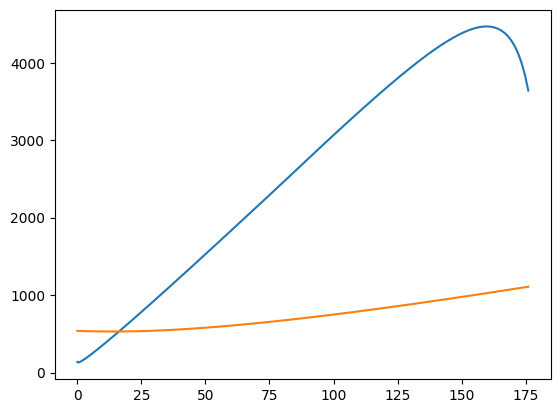

Model saved to trained_value_function.pt


In [5]:
if __name__ == "__main__":
    # Define parameters
    STATE_DIM = 1  # Just one, continuous state, the promised value. Next step will be adding (discrete) y
    ACTION_DIM = 1  # Adjust based on your problem
    HIDDEN_DIMS = [64,64]  # Decreasing width architecture
    pref = Preferences(input_param=p)
    
    LOWER_BOUNDS = [1/pref.utility_1d(p.u_bf_m)]
    UPPER_BOUNDS = [1/pref.utility_1d(10)] #Ideally this should come from fun_prod.max
    # Train value function
    print("Training value function...")
    trained_model = train_value_function(
        state_dim=STATE_DIM,
        lower_bounds=LOWER_BOUNDS,
        upper_bounds=UPPER_BOUNDS,
        action_dim=ACTION_DIM,
        hidden_dims=HIDDEN_DIMS,
        num_iterations=690,
        starting_points_per_iter=200,
        simulation_steps=5,
        learning_rate=0.003,
        parameters=p
    )
    
    # Evaluate trained model
    evaluate_value_function(trained_model, p, LOWER_BOUNDS, UPPER_BOUNDS)
    
    # Save the model
    torch.save(trained_model.state_dict(), "trained_value_function.pt")
    print("Model saved to trained_value_function.pt")

In [22]:
trained_model(torch.tensor([-40.0]))

tensor([3215.1104], grad_fn=<ViewBackward0>)